<font size= 20> network

In [ ]:
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import numpy as np
import timeit
import matplotlib as mpl
import cartopy.feature as cfeature
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import glob
import matplotlib.colors as colors
import intake
import dask
from scipy.spatial import cKDTree
import networkx as nx
import psyplot.project as psy
import pandas as pd
from scipy.stats import pearsonr
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import warnings
from statsmodels.tsa.stattools import grangercausalitytests
import scipy.stats
from scipy import stats

dask.config.set({"array.slicing.split_large_chunks": True}) 

In [ ]:
eerie_cat=intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")
eerie_cat["dkrz.disk.model-output.icon-esm-er.eerie-control-1950.atmos.gr025"]

In [ ]:
eerie_dkrz=eerie_cat["dkrz"]

In [ ]:
eerie_dkrz_disk=eerie_dkrz["disk"]
#for col in eerie_dkrz_disk:
#    print(f"Description of {col}:")
#    print(eerie_dkrz_disk[col].describe()["description"])

In [ ]:
cat=eerie_dkrz_disk["model-output"]["icon-esm-er"]

In [ ]:
searchdict=dict(
    model="ICON",
    realm="atmos",
    exp="eerie-control-1950",
    var="geopotential",
    frequency="daily"
)
subcat=cat
for v in searchdict.values():
    subcat=subcat.search(v)
list(subcat)

# EKE vs FRSHFLUX

In [ ]:
#EKE
ds=cat["eerie-control-1950.ocean.gr025.2d_daily_mean"].to_dask()
#frshflux

atm=cat['eerie-control-1950.atmos.gr025.2d_daily_mean'].to_dask()

In [ ]:
ds= ds.sel(time=slice('2008-01-01T23:59:00.000000000', '2012-01-01T23:59:00.000000000'))
atm=atm.sel(time=slice('2008-01-01T23:59:00.000000000', '2012-01-01T23:59:00.000000000'))

In [ ]:
#calculate EKE
#make the mean
step=20
u_mean=np.mean(ds.u[:,0,::step,::step], axis=0) #mean across axis=0, ovvero il tempo
v_mean=np.mean(ds.v[:,0,::step,::step], axis=0)

#calculate eddy velocities
u_eddy=(ds.u[:,0,::step,::step].values)-(u_mean[:,:].values)
v_eddy=(ds.v[:,0,::step,::step].values)-(v_mean[:,:].values)

#calculate eke
eke_s=(((u_eddy)**2)+((v_eddy)**2))/2

In [ ]:
#calculate EKE
#make the mean
step=20
u_mean=np.mean(ds.u[:,0,::step,::step], axis=0) #mean across axis=0, ovvero il tempo
v_mean=np.mean(ds.v[:,0,::step,::step], axis=0)

#calculate eddy velocities
u_eddy=(ds.u[:,0,::step,::step])-(u_mean[:,:])
v_eddy=(ds.v[:,0,::step,::step])-(v_mean[:,:])

#calculate eke
eke_s=(((u_eddy)**2)+((v_eddy)**2))/2

In [ ]:
step=20
pr=atm['pr'][:,::step,::step]

In [ ]:
eke_monthly=eke_s.resample(time="m").mean()
pr_monthly=pr.resample(time="m").mean()

In [ ]:
pr_monthly=pr_monthly.values
eke_monthly=eke_monthly.values

# SST vs FRSHFLUX or ATMTEMP

In [ ]:
#time=1095 #3 years
ds=cat["eerie-control-1950.ocean.gr025.5lev_daily_mean"].to_dask()
atm=cat['eerie-control-1950.atmos.gr025.2d_daily_mean'].to_dask()
atm2=cat['eerie-control-1950.atmos.gr025.plev19_daily_mean'].to_dask()

In [ ]:
#SELECT  YEARS
ds= ds.sel(time=slice('2013-01-01T23:59:00.000000000', '2016-01-01T23:59:00.000000000'))
atm=atm.sel(time=slice('2013-01-01T23:59:00.000000000', '2016-01-01T23:59:00.000000000'))

In [ ]:
step=20

In [ ]:
to_monthly=ds['to'][:,0,::step,::step].resample(time="m").mean()
pr_monthly=atm['pr'][:,::step,::step].resample(time='m').mean()

In [ ]:
to_monthly=to_monthly.values
pr_monthly=pr_monthly.values

In [ ]:
to_monthly=ds['to'][:time,0,::step,::step].resample(time="m").mean()
tas_monthly=atm['tas'][:time,0,::step,::step].resample(time='m').mean()
pr_monthly=atm['pr'][:time,::step,::step].resample(time='m').mean()

In [ ]:
tas_monthly.values=tas_monthly.values-273.15 #kelvin to celsius

In [ ]:
tas_monthly=tas_monthly.values
to_monthly=to_monthly.values
pr_monthly=pr_monthly.values

# SST vs GEOPOT HEIGHT

In [ ]:
ds=cat["eerie-control-1950.ocean.gr025.2d_daily_mean"].to_dask()
atm2=cat['eerie-control-1950.atmos.gr025.plev19_daily_mean'].to_dask()

In [ ]:
#SELECT  YEARS
ds= ds.sel(time=slice('2013-01-01T23:59:00.000000000', '2016-01-01T23:59:00.000000000'))
atm2=atm2.sel(time=slice('2013-01-01T23:59:00.000000000', '2016-01-01T23:59:00.000000000'))

In [ ]:
#geopotential height
step=20

#find time that correspond to each other because atm2 starts from 2008-01-01
gpsm=atm2['gpsm'][:,7,::step,::step] #il 7 sono 300 hPa
to=ds['to'][:,0,::step,::step] 

In [ ]:
to_monthly=ds['to'][:,0,::step,::step].resample(time="m").mean()
gpsm_monthly=atm2['gpsm'][:,7,::step,::step].resample(time='m').mean()

In [ ]:
to_monthly=ds['to'][:,0,::step,::step].resample(time="W").mean() #do weekly to look for non-el niño timescale


In [ ]:
to_monthly=to_monthly.values
gpsm_monthly=gpsm_monthly.values

# SST vs SPECIFIC HUMIDITY

In [ ]:
ds=cat["eerie-control-1950.ocean.gr025.2d_daily_mean"].to_dask()
atm2=cat['eerie-control-1950.atmos.gr025.plev19_daily_mean'].to_dask()

In [ ]:
ds

In [ ]:
#SELECT YEARS
ds= ds.sel(time=slice('2014-01-01T23:59:00.000000000', '2016-01-01T23:59:00.000000000'))
atm2=atm2.sel(time=slice('2014-01-01T23:59:00.000000000', '2016-01-01T23:59:00.000000000'))

In [ ]:

step=20

#find time that correspond to each other because atm2 starts from 2008-01-01

to=ds['to'][:,0,::step,::step] 
hus=atm2['hus'][:,7,::step,::step] #il 7 sono 300 hPa

In [ ]:
to

In [ ]:
to_monthly=to.resample(time="m").mean()
hus_monthly=hus.resample(time='m').mean()

In [ ]:
to_monthly=to_monthly.values
hus_monthly=hus_monthly.values

# REMOVE SEASONALITY

In [ ]:
#SST

var_season=to_monthly
# Step 1: Plot the original data for one location (assuming one location for simplicity)
location_to_plot = (12, 8)  # latitude and longitude to plot (13,1) corresponds to 40N13E, near sardinia
plt.plot(var_season[:, location_to_plot[0], location_to_plot[1]], label='Original Data')
plt.title("Original Data")
plt.legend()
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose

# Create an empty array to store deseasonalized data
deseason_temp_sst = np.empty_like(var_season)

for lat in range(var_season.shape[1]):
    for lon in range(var_season.shape[2]):
        if np.all(~np.isnan(var_season[:, lat, lon])):
            decomposition = seasonal_decompose(var_season[:, lat, lon], model='additive', period=12)
            deseason_temp_sst[:, lat, lon] = var_season[:, lat, lon] - decomposition.seasonal
        else:
            # If there are NaN values, keep them in the deseasonalized array
            deseason_temp_sst[:, lat, lon] = var_season[:, lat, lon]

# Step 3: Plot the deseasonalized data for one location (assuming one location for simplicity)
plt.plot(deseason_temp_sst[:, location_to_plot[0], location_to_plot[1]], label='Deseasonalized Data')
plt.title("Deseasonalized Data")
plt.legend()
plt.show()



In [ ]:
#PREC
#REMEMBER TO SUBSTITUTE TAS WITH THE CURRENT VARIABLE IN deseason_temp_tas
var_season=pr_monthly
# Step 1: Plot the original data for one location (assuming one location for simplicity)
location_to_plot = (12, 1)  # latitude and longitude to plot (13,1) corresponds to 40N13E, near sardinia
plt.plot(var_season[:, location_to_plot[0], location_to_plot[1]], label='Original Data')
plt.title("Original Data")
plt.legend()
plt.show()

from statsmodels.tsa.seasonal import seasonal_decompose

# Create an empty array to store deseasonalized data
deseason_temp_pr = np.empty_like(var_season)

for lat in range(var_season.shape[1]):
    for lon in range(var_season.shape[2]):
        if np.all(~np.isnan(var_season[:, lat, lon])):
            decomposition = seasonal_decompose(var_season[:, lat, lon], model='additive', period=12)
            deseason_temp_pr[:, lat, lon] = var_season[:, lat, lon] - decomposition.seasonal
        else:
            # If there are NaN values, keep them in the deseasonalized array
            deseason_temp_pr[:, lat, lon] = var_season[:, lat, lon]

# Step 3: Plot the deseasonalized data for one location (assuming one location for simplicity)
plt.plot(deseason_temp_pr[:, location_to_plot[0], location_to_plot[1]], label='Deseasonalized Data')
plt.title("Deseasonalized Data")
plt.legend()
plt.show()



# normalize data
Normalizing by subtracting the mean and dividing by the standard deviation helps remove seasonal trends by making the time series data stationary

In [ ]:
#SST

# Step 1: Calculate the long-term mean and standard deviation for each month
monthly_means = np.mean(deseason_temp_sst, axis=0)
monthly_stddevs = np.std(deseason_temp_sst, axis=0)

# Step 2: Normalize the data
normalized_data_sst = (deseason_temp_sst - monthly_means) / monthly_stddevs

# Now 'normalized_data' contains the normalized values for each data point
location_to_plot = (12, 1)  # latitude and longitude to plot (13,1) corresponds to 40N13E, near sardinia

# Step 6: Plot the normalized data for one location (assuming one location for simplicity)
plt.plot(normalized_data_sst[:, location_to_plot[0], location_to_plot[1]], label='Normalized Data')
plt.title("Normalized Data")
plt.legend()
plt.show()

In [ ]:
#PREC

# Step 1: Calculate the long-term mean and standard deviation for each month
monthly_means = np.mean(deseason_temp_pr, axis=0)
monthly_stddevs = np.std(deseason_temp_pr, axis=0)

# Step 2: Normalize the data
normalized_data_pr = (deseason_temp_pr - monthly_means) / monthly_stddevs

# Now 'normalized_data' contains the normalized values for each data point
location_to_plot = (12, 1)  # latitude and longitude to plot (13,1) corresponds to 40N13E, near sardinia

# Step 6: Plot the normalized data for one location (assuming one location for simplicity)
plt.plot(normalized_data_pr[:, location_to_plot[0], location_to_plot[1]], label='Normalized Data')
plt.title("Normalized Data")
plt.legend()
plt.show()

In [ ]:
normalized_data_sst.shape

In [ ]:
normalized_data_tas.shape

# Plot EKE

In [ ]:

lon_mesh, lat_mesh = np.meshgrid(ds.lon[::step], ds.lat[::step])



# plot using the simple scatter method:
plt.figure(figsize=(15,10))
# plot using Robinson projection.
ax = plt.axes(projection= ccrs.PlateCarree())
ax.coastlines(resolution='110m', color='k')

# Fill the continents with a color
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.set_title('Eddy kinetic energy'+'\n'+'19th of December 2020 T00:00', size='xx-large')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')

sc=ax.scatter(lon_mesh,lat_mesh,  c=to[0,:,:], s=4 ,cmap='viridis',
              transform=ccrs.PlateCarree(), vmax=0.03)#,vmin=np.min(cut_eke[np.nonzero(cut_eke)]),              vmax=0.05)
# Add colorbar
cbar=plt.colorbar(sc,orientation='horizontal', pad=0.04)
cbar.set_label(r'$m^{2} s^{-2}$')


<font size=20> Network creation

In [ ]:
from concurrent.futures import ProcessPoolExecutor
n_cpu = 48 #48 is optimal
#max number of CPUs I can use is the number of latitudes we have

In [ ]:
#world vs world: NO threshold NO anomalies


latitudes = ds.lat.values[::step]
longitudes = ds.lon.values[::step]

eke_downsized = to_monthly
frshflux_downsized = tas_monthly

# Get the dimensions of the downsized arrays
num_time_steps, num_latitudes, num_longitudes = eke_downsized.shape



# Set the correlation threshold
correlation_threshold = 0.9
# Define a function for parallelizing the computation of correlation
def correlation_parallel_func(lat_lon):
    lat, lon = lat_lon
    S = nx.Graph()
    if not np.any(np.isnan(eke_downsized[:, lat, lon])):
        # Extract time series at the current 'eke' position
        time_series_eke = eke_downsized[:, lat, lon]

        # Iterate over all positions (lat, lon) for 'frshflux'
        for lat_frshflux in range(num_latitudes):
            for lon_frshflux in range(num_longitudes):
                if not np.any(np.isnan(frshflux_downsized[:, lat_frshflux, lon_frshflux])):
                    # Extract time series at the current 'frshflux' position
                    time_series_frshflux = frshflux_downsized[:, lat_frshflux, lon_frshflux]

                    # Check for NaN values
                    if not (np.any(np.isnan(time_series_eke)) or np.any(np.isnan(time_series_frshflux))):
                        # Calculate Pearson correlation coefficient
                        correlation, _ = pearsonr(time_series_eke, time_series_frshflux)

                        # Check if correlation is above the threshold
                        if abs(correlation) > correlation_threshold:
                            # Add nodes to the graph
                            node_eke = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], 'eke')
                            node_frshflux = (ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux], 'frshflux')
                            S.add_node(node_eke)
                            S.add_node(node_frshflux)

                            # Add weighted edge with correlation coefficient as weight
                            S.add_weighted_edges_from([(node_eke, node_frshflux, correlation)])
    return S

# Measure the total computation time
start_time_total = timeit.default_timer()

# Use executor.map to parallelize the computation of correlation
with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    S_list = list(executor.map(correlation_parallel_func, [(lat, lon) for lat in range(num_latitudes) for lon in range(num_longitudes)]))

end_time_total = timeit.default_timer()

# Print the total computation time
print(f"Total computation time for the entire script: {end_time_total - start_time_total:.2f} seconds")

# Access individual results
final_S_list = [result for result in S_list]






<font size=10> world vs world: With distance threshold

In [ ]:
from concurrent.futures import ProcessPoolExecutor
n_cpu = 48 #48 is optimal
#max number of CPUs I can use is the number of latitudes we have

In [ ]:
eke_downsized.shape

In [ ]:
#world vs world: distance threshold  CURRENTTTT


latitudes = ds.lat.values[::step]
longitudes = ds.lon.values[::step]

eke_downsized = normalized_data_sst
frshflux_downsized = normalized_data_sst

# Get the dimensions of the downsized arrays
num_time_steps, num_latitudes, num_longitudes = eke_downsized.shape
correlation_threshold=0.8


def correlation_parallel_func(lat_lon):
    lat, lon = lat_lon
    S = nx.Graph()
    
    # Function to calculate distance between two points in degrees
    def calculate_distance(lat1, lon1, lat2, lon2):
        lat_diff = abs(lat1 - lat2)
        lon_diff = abs(lon1 - lon2)
        return lat_diff, lon_diff
    
    if not np.any(np.isnan(eke_downsized[:, lat, lon])):
        # Extract time series at the current 'eke' position
        time_series_eke = eke_downsized[:, lat, lon]

        # Iterate over all positions (lat, lon) for 'frshflux'
        for lat_frshflux in range(num_latitudes):
            for lon_frshflux in range(num_longitudes):
                if not np.any(np.isnan(frshflux_downsized[:, lat_frshflux, lon_frshflux])):
                    # Extract time series at the current 'frshflux' position
                    time_series_frshflux = frshflux_downsized[:, lat_frshflux, lon_frshflux]

                    correlation, _ = pearsonr(time_series_eke, time_series_frshflux)

                    # Check if correlation is above the threshold and nodes are far enough apart
                    if abs(correlation) > correlation_threshold:
                        dist_lat, dist_lon = calculate_distance(
                            ds.lat.values[::step][lat], ds.lon.values[::step][lon],
                            ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux]
                        )

                        # Check if nodes are at least x degrees apart
                        if dist_lat >= 15 and dist_lon >= 15:
                            # Add nodes to the graph
                            node_eke = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], 'eke')
                            node_frshflux = (ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux], 'frshflux')
                            S.add_node(node_eke)
                            S.add_node(node_frshflux)

                            # Add weighted edge with correlation coefficient as weight
                            S.add_weighted_edges_from([(node_eke, node_frshflux, correlation)])
                            
    return S


# Measure the total computation time
start_time_total = timeit.default_timer()

# Use executor.map to parallelize the computation of correlation
with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    S_list = list(executor.map(correlation_parallel_func, [(lat, lon) for lat in range(num_latitudes) for lon in range(num_longitudes)]))

end_time_total = timeit.default_timer()

# Print the total computation time
print(f"Total computation time for the entire script: {end_time_total - start_time_total:.2f} seconds")

# Access individual results
final_S_list = [result for result in S_list]


In [ ]:
W=nx.Graph()
W = nx.compose_all(final_S_list)


In [ ]:
#SAVE
# Convert node tuples to strings before saving
#W_str_labels = nx.relabel_nodes(W, {node: str(node) for node in W.nodes()})

# Save the graph to a GraphML file
#nx.write_graphml(W_str_labels, "sst_anomalies_2001_2021_step10.graphml")

In [ ]:
W.number_of_nodes()

<font size=10> GRANGER: world vs world: With distance threshold

In [ ]:
granger_causality_test(normalized_data_sst[:,14,8], normalized_data_tas[:,14,8])

In [ ]:

# Assuming 'normalized_data_sst' and 'normalized_data_tas' are your downsized and normalized data arrays
eke_downsized = normalized_data_sst
frshflux_downsized = normalized_data_sst

# Get the dimensions of the downsized arrays
num_time_steps, num_latitudes, num_longitudes = eke_downsized.shape

def granger_causality_test(time_series1, time_series2, max_lag=5):
    # Perform Granger causality test
    data = np.column_stack((time_series1, time_series2))
    results = grangercausalitytests(data, max_lag, verbose=False)

    # Get p-value from the test
    p_value = results[max_lag][0]['ssr_ftest'][1]

    return p_value

def calculate_distance(lat1, lon1, lat2, lon2):
    # Function to calculate distance between two points in degrees
    lat_diff = abs(lat1 - lat2)
    lon_diff = abs(lon1 - lon2)
    return lat_diff, lon_diff

def correlation_parallel_func(lat_lon):
    lat, lon = lat_lon
    S = nx.Graph()
    
    if not np.any(np.isnan(eke_downsized[:, lat, lon])):
        # Extract time series at the current 'eke' position
        time_series_eke = eke_downsized[:, lat, lon]

        # Iterate over all positions (lat, lon) for 'frshflux'
        for lat_frshflux in range(num_latitudes):
            for lon_frshflux in range(num_longitudes):
                if not np.any(np.isnan(frshflux_downsized[:, lat_frshflux, lon_frshflux])):
                    # Extract time series at the current 'frshflux' position
                    time_series_frshflux = frshflux_downsized[:, lat_frshflux, lon_frshflux]

                    # Calculate Granger causality
                    p_value = granger_causality_test(time_series_eke, time_series_frshflux)
                    

                    # Check if p-value is below the threshold and nodes are far enough apart
                    if p_value < 0.05:
                        dist_lat, dist_lon = calculate_distance(
                            ds.lat.values[::step][lat], ds.lon.values[::step][lon],
                            ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux]
                        )

                        # Check if nodes are at least x degrees apart
                        if dist_lat >= 30 and dist_lon >= 30:
                            # Add nodes to the graph
                            node_eke = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], 'eke')
                            node_frshflux = (ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux], 'frshflux')
                            S.add_node(node_eke)
                            S.add_node(node_frshflux)

                            # Add weighted edge with Granger causality p-value as weight
                            S.add_weighted_edges_from([(node_eke, node_frshflux, 1/p_value)])  # Inverse p-value as weight
                            
    return S

# Measure the total computation time
start_time_total = timeit.default_timer()

# Use executor.map to parallelize the computation of correlation
with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    S_list = list(executor.map(correlation_parallel_func, [(lat, lon) for lat in range(num_latitudes) for lon in range(num_longitudes)]))

end_time_total = timeit.default_timer()

# Print the total computation time
print(f"Total computation time for the entire script: {end_time_total - start_time_total:.2f} seconds")

# Access individual results
final_S_list = [result for result in S_list]


In [ ]:
W=nx.Graph()
W = nx.compose_all(final_S_list)


In [ ]:
W.number_of_nodes()

In [ ]:
normalized_data_tas[:,13,8]

<font size=10> GRANGER: tropics vs world: With distance threshold

In [ ]:
# Assuming 'normalized_data_sst' and 'normalized_data_tas' are your downsized and normalized data arrays
eke_downsized = normalized_data_sst
frshflux_downsized = normalized_data_sst

# Define the latitude range for the tropics (adjust as needed)
tropic_lat_range = (-23.5, 23.5)

# Get the indices of the latitudes within the tropical range
tropic_lat_indices = np.where((ds.lat.values >= tropic_lat_range[0]) & (ds.lat.values <= tropic_lat_range[1]))[0]

# Get the dimensions of the downsized arrays
num_time_steps, num_latitudes, num_longitudes = eke_downsized.shape

def granger_causality_test(time_series1, time_series2, max_lag=6):
    # Perform Granger causality test
    data = np.column_stack((time_series1, time_series2))
    results = grangercausalitytests(data, max_lag, verbose=False)

    # Get p-value from the test
    p_value = results[max_lag][0]['ssr_ftest'][1]

    return p_value

def calculate_distance(lat1, lon1, lat2, lon2):
    # Function to calculate distance between two points in degrees
    lat_diff = abs(lat1 - lat2)
    lon_diff = abs(lon1 - lon2)
    return lat_diff, lon_diff

def correlation_parallel_func(lat_lon):
    lat, lon = lat_lon
    S = nx.Graph()
    
    if lat in tropic_lat_indices:  # Check if the latitude is within the tropics
        if not np.any(np.isnan(eke_downsized[:, lat, lon])):
            # Extract time series at the current 'eke' position
            time_series_eke = eke_downsized[:, lat, lon]

            # Iterate over all positions (lat, lon) for 'frshflux'
            for lat_frshflux in range(num_latitudes):
                for lon_frshflux in range(num_longitudes):
                    if not np.any(np.isnan(frshflux_downsized[:, lat_frshflux, lon_frshflux])):
                        # Extract time series at the current 'frshflux' position
                        time_series_frshflux = frshflux_downsized[:, lat_frshflux, lon_frshflux]

                        # Calculate Granger causality
                        p_value = granger_causality_test(time_series_eke, time_series_frshflux)

                        # Check if p-value is below the threshold and nodes are far enough apart
                        if p_value < 0.08:
                            dist_lat, dist_lon = calculate_distance(
                                ds.lat.values[::step][lat], ds.lon.values[::step][lon],
                                ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux]
                            )

                            # Check if nodes are at least x degrees apart
                            if dist_lat >=30 and dist_lon >=30:
                                # Add nodes to the graph
                                node_eke = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], 'eke')
                                node_frshflux = (ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux], 'frshflux')
                                S.add_node(node_eke)
                                S.add_node(node_frshflux)

                                # Add weighted edge with Granger causality p-value as weight
                                S.add_weighted_edges_from([(node_eke, node_frshflux, 1/p_value)])  # Inverse p-value as weight
                                
    return S

# Measure the total computation time
start_time_total = timeit.default_timer()

# Use executor.map to parallelize the computation of correlation
with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    S_list = list(executor.map(correlation_parallel_func, [(lat, lon) for lat in range(num_latitudes) for lon in range(num_longitudes)]))

end_time_total = timeit.default_timer()

# Print the total computation time
print(f"Total computation time for the entire script: {end_time_total - start_time_total:.2f} seconds")

# Access individual results
final_S_list = [result for result in S_list]


In [ ]:
W=nx.Graph()
W = nx.compose_all(final_S_list)


In [ ]:
W.number_of_nodes()

<font size=10> world vs world: anomalies + distance threshold

In [34]:
from concurrent.futures import ProcessPoolExecutor
n_cpu = 48 #48 is optimal
#max number of CPUs I can use is the number of latitudes we have

In [ ]:
#world vs world: distance threshold
#Without close nodes: in this one we take out any possible edge between geographically close nodes

latitudes = ds.lat.values[::step]
longitudes = ds.lon.values[::step]

eke_downsized = normalized_data
frshflux_downsized = normalized_data

# Get the dimensions of the downsized arrays
num_time_steps, num_latitudes, num_longitudes = eke_downsized.shape
correlation_threshold=0.7
# Calculate the 5th percentile for 'eke' time series
threshold_eke_low = np.percentile(eke_downsized[~np.isnan(eke_downsized)], 10)

# Calculate the 5th percentile for 'frshflux' time series
threshold_frshflux_low = np.percentile(frshflux_downsized[~np.isnan(frshflux_downsized)], 10)

# Calculate the 95th percentile for 'eke' time series
threshold_eke_high = np.percentile(eke_downsized[~np.isnan(eke_downsized)], 90)

# Calculate the 95th percentile for 'frshflux' time series
threshold_frshflux_high = np.percentile(frshflux_downsized[~np.isnan(frshflux_downsized)], 90)

def correlation_parallel_func(lat_lon):
    lat, lon = lat_lon
    S = nx.Graph()
    
    # Function to calculate distance between two points in degrees
    def calculate_distance(lat1, lon1, lat2, lon2):
        lat_diff = abs(lat1 - lat2)
        lon_diff = abs(lon1 - lon2)
        return lat_diff, lon_diff
    
    if not np.any(np.isnan(eke_downsized[:, lat, lon])):
        # Extract time series at the current 'eke' position
        time_series_eke = eke_downsized[:, lat, lon]

        # Iterate over all positions (lat, lon) for 'frshflux'
        for lat_frshflux in range(num_latitudes):
            for lon_frshflux in range(num_longitudes):
                if not np.any(np.isnan(frshflux_downsized[:, lat_frshflux, lon_frshflux])):
                    # Extract time series at the current 'frshflux' position
                    time_series_frshflux = frshflux_downsized[:, lat_frshflux, lon_frshflux]

                    # Check if both time series have values above their respective 95th and 0.5th percentiles
                    if np.any((time_series_eke > threshold_eke_high) & (time_series_eke < threshold_eke_low)) and \
                       np.any((time_series_frshflux > threshold_frshflux_high) & (time_series_frshflux < threshold_frshflux_low)):
                        # Calculate Pearson correlation coefficient
                        correlation, _ = pearsonr(time_series_eke, time_series_frshflux)

                        # Check if correlation is above the threshold and nodes are far enough apart
                        if abs(correlation) > correlation_threshold:
                            dist_lat, dist_lon = calculate_distance(
                                ds.lat.values[::step][lat], ds.lon.values[::step][lon],
                                ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux]
                            )

                            # Check if nodes are at least distance degrees apart
                            if dist_lat >= 0 and dist_lon >= 0:
                                # Add nodes to the graph
                                node_eke = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], 'eke')
                                node_frshflux = (ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux], 'frshflux')
                                S.add_node(node_eke)
                                S.add_node(node_frshflux)

                                # Add weighted edge with correlation coefficient as weight
                                S.add_weighted_edges_from([(node_eke, node_frshflux, correlation)])
    return S


# Measure the total computation time
start_time_total = timeit.default_timer()

# Use executor.map to parallelize the computation of correlation
with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    S_list = list(executor.map(correlation_parallel_func, [(lat, lon) for lat in range(num_latitudes) for lon in range(num_longitudes)]))

end_time_total = timeit.default_timer()

# Print the total computation time
print(f"Total computation time for the entire script: {end_time_total - start_time_total:.2f} seconds")

# Access individual results
final_S_list = [result for result in S_list]


In [ ]:
W=nx.Graph()
W = nx.compose_all(final_S_list)

In [ ]:
W.number_of_edges()

<font size=10> world vs world (only SST): anomalies + distance threshold

In [ ]:


latitudes = ds.lat.values[::step]
longitudes = ds.lon.values[::step]




# Function to calculate distance between two points in degrees
def calculate_distance(lat1, lon1, lat2, lon2):
    lat_diff = abs(lat1 - lat2)
    lon_diff = abs(lon1 - lon2)
    return lat_diff, lon_diff

# Define a function to calculate the 95th percentile for each grid point
def calculate_percentile(data, percentile=95):
    return np.percentile(data, percentile, axis=0)

# Get the 95th percentile for each grid point in tas_monthly
tas_percentile_95 = calculate_percentile(to_monthly)
correlation_threshold=-0.9
# Define a function for parallelizing the computation of correlation
def correlation_parallel_func(lat_lon):
    lat, lon = lat_lon
    S = nx.Graph()

    # Extract time series at the current position
    time_series = to_monthly[:, lat, lon]

    # Check for NaN values
    if not np.any(np.isnan(time_series)):
        # Get the 95th percentile for the current grid point in to_monthly
        threshold_to_monthly = np.percentile(time_series, 95)

        # Iterate over all positions (lat, lon) in the dataset
        for lat_tas in range(num_latitudes):
            for lon_tas in range(num_longitudes):
                if (lat, lon) != (lat_tas, lon_tas):  # Skip the same position
                    # Check if nodes are at least 2 degrees apart
                    dist_lat, dist_lon = calculate_distance(
                        ds.lat.values[::step][lat], ds.lon.values[::step][lon],
                        ds.lat.values[::step][lat_tas], ds.lon.values[::step][lon_tas]
                    )

                    if dist_lat >= 50 and dist_lon >= 50:
                        # Extract time series at the current position
                        time_series_tas = to_monthly[:, lat_tas, lon_tas]

                        # Check for NaN values
                        if not np.any(np.isnan(time_series_tas)):
                            # Check if temperatures in to_monthly are above the 95th percentile
                            if np.all(time_series_tas > threshold_to_monthly):
                                # Calculate Pearson correlation coefficient
                                correlation, _ = pearsonr(time_series, time_series_tas)

                                # Check if correlation is above the threshold
                                if correlation < correlation_threshold:
                                    # Add nodes to the graph
                                    node_current = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], 'eke')
                                    node_other = (ds.lat.values[::step][lat_tas], ds.lon.values[::step][lon_tas], 'frshflux')
                                    S.add_node(node_current)
                                    S.add_node(node_other)

                                    # Add weighted edge with correlation coefficient as weight
                                    S.add_weighted_edges_from([(node_current, node_other, correlation)])
    return S


# Measure the total computation time
start_time_total = timeit.default_timer()

# Use executor.map to parallelize the computation of correlation
with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    S_list = list(executor.map(correlation_parallel_func, [(lat, lon) for lat in range(num_latitudes) for lon in range(num_longitudes)]))

end_time_total = timeit.default_timer()

# Print the total computation time
print(f"Total computation time for the entire script: {end_time_total - start_time_total:.2f} seconds")

# Access individual results
final_S_list = [result for result in S_list]

In [ ]:
W=nx.Graph()
W = nx.compose_all(final_S_list)

In [ ]:
W.number_of_nodes()

<font size=10> tropics vs world: With distance threshold

In [43]:
latitudes = ds.lat.values[::step]
longitudes = ds.lon.values[::step]

eke_downsized = normalized_data_sst
frshflux_downsized = normalized_data_pr

# Get the dimensions of the downsized arrays
num_time_steps, num_latitudes, num_longitudes = eke_downsized.shape
correlation_threshold=0.8
# Define the latitude bounds for the tropics (e.g., between -23.5 and 23.5 degrees)
tropics_lat_bounds = (-23.5, 23.5)

# Function to check if a latitude is within the tropics
def is_in_tropics(lat):
    return tropics_lat_bounds[0] <= lat <= tropics_lat_bounds[1]

# Function to calculate distance between two points in degrees
def calculate_distance(lat1, lon1, lat2, lon2):
    lat_diff = abs(lat1 - lat2)
    lon_diff = abs(lon1 - lon2)
    return lat_diff, lon_diff

# Define a function for parallelizing the computation of correlation
def correlation_parallel_func(lat_lon):
    lat, lon = lat_lon
    S = nx.Graph()

    # Check if the latitude is within the tropics for to_monthly
    if is_in_tropics(ds.lat.values[::step][lat]):
        # Extract time series at the current 'to_monthly' position
        time_series_to_monthly = eke_downsized[:, lat, lon]

        # Iterate over all positions (lat, lon) for 'tas_monthly'
        for lat_tas in range(num_latitudes):
            for lon_tas in range(num_longitudes):
                # Extract time series at the current 'tas_monthly' position
                time_series_tas = frshflux_downsized[:, lat_tas, lon_tas]

                # Check for NaN values
                if not (np.any(np.isnan(time_series_to_monthly)) or np.any(np.isnan(time_series_tas))):
                    # Calculate Pearson correlation coefficient
                    correlation, _ = pearsonr(time_series_to_monthly, time_series_tas)

                    # Check if correlation is above the threshold and nodes are far enough apart
                    if abs(correlation) > correlation_threshold:
                        dist_lat, dist_lon = calculate_distance(
                            ds.lat.values[::step][lat], ds.lon.values[::step][lon],
                            ds.lat.values[::step][lat_tas], ds.lon.values[::step][lon_tas]
                        )

                        # Check if nodes are at least 2 degrees apart
                        if dist_lat >= 20 and dist_lon >= 20:
                            # Add nodes to the graph
                            node_to_monthly = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], 'eke')
                            node_tas_monthly = (ds.lat.values[::step][lat_tas], ds.lon.values[::step][lon_tas], 'frshflux')
                            S.add_node(node_to_monthly)
                            S.add_node(node_tas_monthly)

                            # Add weighted edge with correlation coefficient as weight
                            S.add_weighted_edges_from([(node_to_monthly, node_tas_monthly, correlation)])
    return S

# Measure the total computation time
start_time_total = timeit.default_timer()

# Use executor.map to parallelize the computation of correlation
with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    S_list = list(executor.map(correlation_parallel_func, [(lat, lon) for lat in range(num_latitudes) for lon in range(num_longitudes)]))

end_time_total = timeit.default_timer()

# Print the total computation time
print(f"Total computation time for the entire script: {end_time_total - start_time_total:.2f} seconds")

# Access individual results
final_S_list = [result for result in S_list]


Total computation time for the entire script: 4.54 seconds


In [44]:
W=nx.Graph()
W = nx.compose_all(final_S_list)



In [45]:
W.number_of_nodes()

13

<font size=10> tropics vs world: anomalies + distance threshold

In [ ]:
#tropics vs world: distance and anomalies




latitudes = ds.lat.values[::step]
longitudes = ds.lon.values[::step]

eke_downsized = normalized_data
frshflux_downsized = normalized_data

# Get the dimensions of the downsized arrays
num_time_steps, num_latitudes, num_longitudes = eke_downsized.shape

correlation_threshold = 0.9

# Define the latitude bounds for the tropics (e.g., between -23.5 and 23.5 degrees)
tropics_lat_bounds = (-23.5, 23.5)

# Function to check if a latitude is within the tropics
def is_in_tropics(lat):
    return tropics_lat_bounds[0] <= lat <= tropics_lat_bounds[1]

# Function to calculate distance between two points in degrees
def calculate_distance(lat1, lon1, lat2, lon2):
    lat_diff = abs(lat1 - lat2)
    lon_diff = abs(lon1 - lon2)
    return lat_diff, lon_diff

# Define a function to calculate the 95th percentile for each grid point
def calculate_percentile(data, percentile=9):
    return np.percentile(data, percentile, axis=0)

# ...

# Get the 95th percentile for each grid point in tas_monthly
tas_percentile_95 = calculate_percentile(to_monthly)

def correlation_parallel_func(lat_lon):
    lat, lon = lat_lon
    S = nx.Graph()

    # Check if the latitude is within the tropics for to_monthly
    if is_in_tropics(ds.lat.values[::step][lat]):
    
        # Extract time series at the current 'to_monthly' position
        time_series_to_monthly = to_monthly[:, lat, lon]

        # Get the 95th percentile threshold for the current grid point in tas_monthly
        threshold_tas = tas_percentile_95[lat, lon]

        # Iterate over all positions (lat, lon) for 'tas_monthly'
        for lat_tas in range(num_latitudes):
            for lon_tas in range(num_longitudes):
                # Check if the latitude is within the tropics for tas_monthly
                if not is_in_tropics(ds.lat.values[::step][lat_tas]):
                    # Extract time series at the current 'tas_monthly' position
                    time_series_tas = frshflux_downsized[:, lat_tas, lon_tas]

                    # Check for NaN values
                    if not (np.any(np.isnan(time_series_to_monthly)) or np.any(np.isnan(time_series_tas))):
                        # Check if temperatures in tas_monthly are above the 95th percentile
                        if np.all(time_series_tas > threshold_tas):
                            # Calculate Pearson correlation coefficient
                            correlation, _ = pearsonr(time_series_to_monthly, time_series_tas)

                            # Check if correlation is above the threshold and nodes are at least 2 degrees apart
                            if abs(correlation) > correlation_threshold:
                                dist_lat, dist_lon = calculate_distance(
                                    ds.lat.values[::step][lat], ds.lon.values[::step][lon],
                                    ds.lat.values[::step][lat_tas], ds.lon.values[::step][lon_tas]
                                )

                                # Check if nodes are at least 2 degrees apart
                                if dist_lat >= 30 and dist_lon >= 30:
                                    # Add nodes to the graph
                                    node_to_monthly = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], 'eke')
                                    node_tas_monthly = (ds.lat.values[::step][lat_tas], ds.lon.values[::step][lon_tas], 'frshflux')
                                    S.add_node(node_to_monthly)
                                    S.add_node(node_tas_monthly)

                                    # Add weighted edge with correlation coefficient as weight
                                    S.add_weighted_edges_from([(node_to_monthly, node_tas_monthly, correlation)])
    return S


# Measure the total computation time
start_time_total = timeit.default_timer()

# Use executor.map to parallelize the computation of correlation
with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    S_list = list(executor.map(correlation_parallel_func, [(lat, lon) for lat in range(num_latitudes) for lon in range(num_longitudes)]))

end_time_total = timeit.default_timer()

# Print the total computation time
print(f"Total computation time for the entire script: {end_time_total - start_time_total:.2f} seconds")

# Access individual results
final_S_list = [result for result in S_list]


In [ ]:
W=nx.Graph()
for i in range(len(final_S_list)):
    W=nx.compose(W,final_S_list[i])

In [ ]:
W.number_of_edges()

In [ ]:
W.number_of_edges()

<font size=30> PLOT

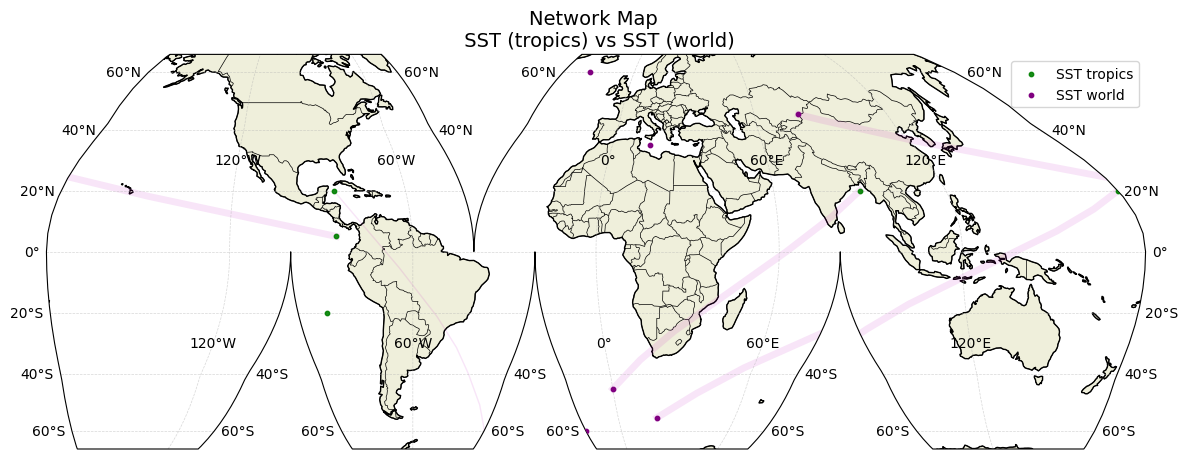

In [38]:
# 

# Generate layout for visualization with Cartopy (changes to long,lat)
pos = {node: (np.mod(node[1], 360), node[0]) for node in W.nodes()} # No need to modify longitudes, assuming they are already in the range -180 to +180

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.InterruptedGoodeHomolosine()})
# ax.set_global()
# ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
#ax.set_extent([-180, 180, -90, 90], crs=ccrs.InterruptedGoodeHomolosine())
# Add world map and gridlines
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='dashed', alpha=0.5, draw_labels=True)

# Extract edge weights for edge width
edge_weights = [data['weight'] for _, _, data in W.edges(data=True)]

# Separate nodes based on type
eke_nodes = [node for node in W.nodes() if node[2] == 'eke']
frshflux_nodes = [node for node in W.nodes() if node[2] == 'frshflux']

#PARTE VECCHIA======================================================================
#for edge, weight in zip(G.edges(), edge_weights):
#    normalized_weight = (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))  # Normalize weights between 0 and 1
#    edge_width = 1 + 4 * normalized_weight  # Adjust the multiplier for the desired range of edge widths
#    ax.plot([pos[edge[0]][0], pos[edge[1]][0]],
#            [pos[edge[0]][1], pos[edge[1]][1]], 
#            alpha=0.1, color="m", linewidth=edge_width)

# Plot nodes
#ax.scatter([pos[node][0] for node in eke_nodes], [np.mod(pos[node][1],180) for node in eke_nodes], s=10, color="red", alpha=0.9, label='eke',zorder=20001)
#ax.scatter([pos[node][0] for node in frshflux_nodes], [pos[node][1] for node in frshflux_nodes], s=10, color="blue", alpha=1, label='frshflux',zorder=20001)
#======================================================================



#QUI CONTROLLA CHE COSA SUCCEDE ALLE LOGNITUDINI E LATITUDINI============================================
for edge, weight in zip(W.edges(), edge_weights):
    normalized_weight = (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))
    edge_width = 1 + 4 * normalized_weight
    #print("prima",pos[edge[0]][1], pos[edge[1]][1])
    lon1 = (np.mod(pos[edge[0]][1], 180))
    lon2 = (pos[edge[1]][1])

    
    ax.plot([pos[edge[0]][0], pos[edge[1]][0]], [lon1, lon2], alpha=0.1, color="m", linewidth=edge_width, transform=ccrs.PlateCarree())

# Plot nodes
ax.scatter([pos[node][0] for node in eke_nodes], [pos[node][1] for node in eke_nodes], 
           s=10, color="green", alpha=0.9, label='SST tropics', zorder=20001, transform=ccrs.PlateCarree())
ax.scatter([pos[node][0] for node in frshflux_nodes], [pos[node][1] for node in frshflux_nodes],
           s=10, color="purple", alpha=1, label='SST world', zorder=20001, transform=ccrs.PlateCarree())
#======================================================================


font = {"fontname": "Helvetica", "color": "k",  "fontsize": 14}
ax.set_title("Network Map \n SST (tropics) vs SST (world)", font)
text1 = AnchoredText("monthly data 2013-2016, res=5deg",
                    loc=3, prop={'size': 8.5}, frameon=True, zorder=24000)



ax.legend()

# Change font color for legend
#font["color"] = "r"


# Resize figure for label readability
ax.margins(0.1, 0.05)
#fig.savefig()
fig.tight_layout()
plt.show()


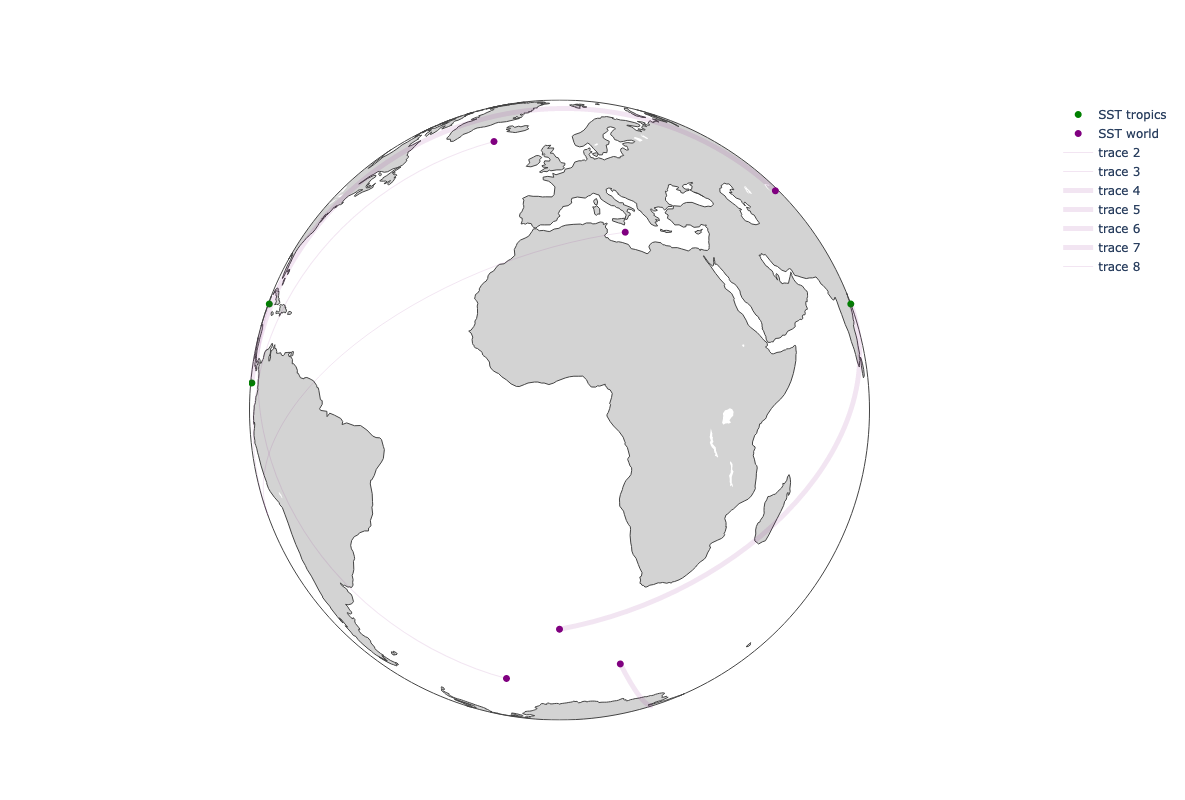

In [46]:
import plotly.graph_objects as go

pos = {node: (np.mod(node[1], 360), node[0]) for node in W.nodes()}  # No need to modify longitudes, assuming they are already in the range -180 to +180

# Extract edge weights for edge width
edge_weights = [data['weight'] for _, _, data in W.edges(data=True)]

# Separate nodes based on type
eke_nodes = [node for node in W.nodes() if node[2] == 'eke']
frshflux_nodes = [node for node in W.nodes() if node[2] == 'frshflux']

# Create a Plotly graph object
fig = go.Figure()

# Plot 'eke' nodes
fig.add_trace(go.Scattergeo(
    lon=[pos[node][0] for node in eke_nodes],
    lat=[pos[node][1] for node in eke_nodes],
    mode='markers',
    marker=dict(
        size=7,
        color="green",
    ),
    name='SST tropics',
))

# Plot 'frshflux' nodes
fig.add_trace(go.Scattergeo(
    lon=[pos[node][0] for node in frshflux_nodes],
    lat=[pos[node][1] for node in frshflux_nodes],
    mode='markers',
    marker=dict(
        size=7,
        color="purple",
    ),
    name='SST world',
))

# Plot edges
for edge, weight in zip(W.edges(), edge_weights):
    normalized_weight = (weight - min(edge_weights)) / (max(edge_weights) - min(edge_weights))
    edge_width = 1 + 4 * normalized_weight
    fig.add_trace(go.Scattergeo(
        lon=[pos[edge[0]][0], pos[edge[1]][0], None],  # None to create a gap between segments
        lat=[pos[edge[0]][1], pos[edge[1]][1], None],
        mode='lines',
        line=dict(
            width=edge_width,
            color='rgba(128, 0, 128, 0.1)',
        ),
        text=f'Correlation: {weight}',
        hoverinfo='text',
    ))

# Update layout for better visibility
fig.update_layout(
    geo=dict(
        showland=True,
        landcolor="#D3D3D3",  # Set the color for the land
        projection_type="orthographic"
    ),
    width=1000,  # Set the width of the plot
    height=800   # Set the height of the plot
)

# Set legend entries
fig.update_layout(
    legend=dict(
        traceorder='normal',
    ),
)

# Save the plot as an HTML file
#fig.write_html("SSTtropSSTwrld_2013_16_step20.html")

# Show the plot
fig.show()


# node degree map

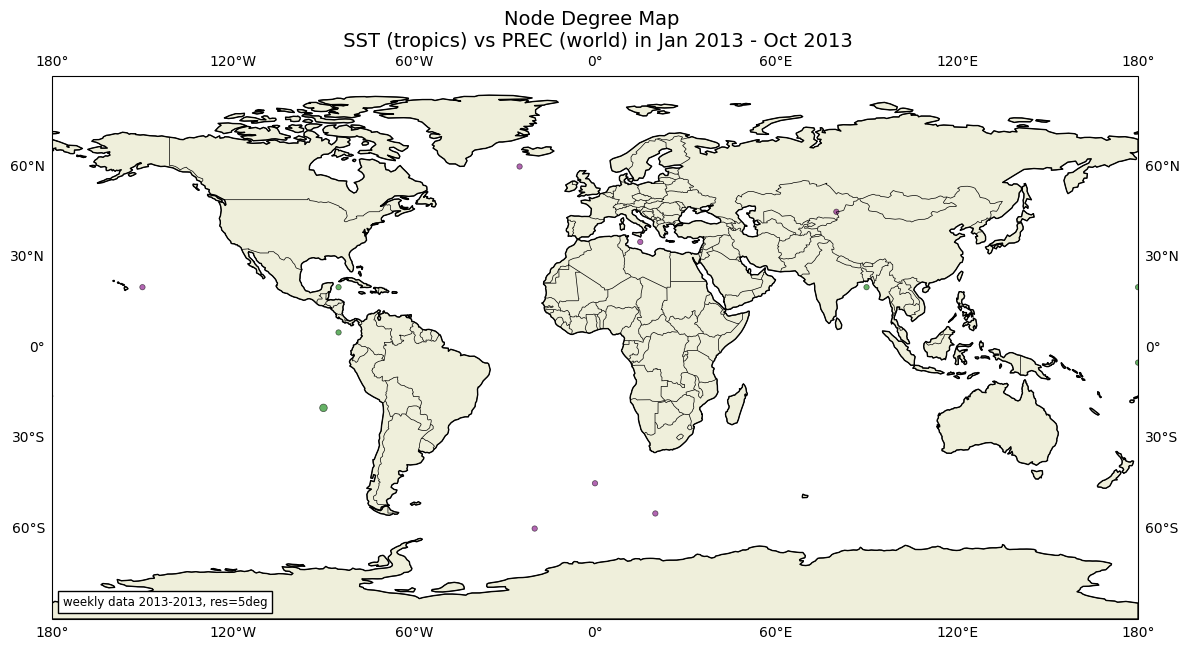

In [48]:


# Generate layout for visualization with Cartopy
pos = {node: (node[1], node[0]) for node in W.nodes()}  # Convert longitudes to the range -180 to +180

# Calculate node degrees
degrees = dict(W.degree())

# Extract node positions, sizes, and colors based on node type
node_positions = np.array([pos[node] for node in W.nodes()])
node_sizes = np.array([degrees[node] for node in W.nodes()])
node_colors = ['green' if node[2] == 'eke' else 'purple' for node in W.nodes()]

# Create a scatter plot with node sizes proportional to degree and colors based on type
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# Scatter plot nodes with a small black dot at the center
sc = ax.scatter(
    node_positions[:, 0], node_positions[:, 1], s=node_sizes * 15,
    c=node_colors, alpha=0.6, edgecolors='k', linewidths=0.5
)

# Add a black dot at the center of each circle representing a node
#ax.scatter(node_positions[:, 0], node_positions[:, 1], color='black', s=2)

# Set the geographical extent to cover the entire world
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add world map and gridlines
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='dashed', alpha=0, draw_labels=True)

# Title
font = {"fontname": "Helvetica", "color": "k",  "fontsize": 14}
ax.set_title("Node Degree Map \n SST (tropics) vs PREC (world) in Jan 2013 - Oct 2013", font)
text1 = AnchoredText("weekly data 2013-2013, res=5deg",
                    loc=3, prop={'size': 8.5}, frameon=True, zorder=24000)
ax.add_artist(text1)


# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
#fig.savefig("SSTtropSSTwrld_2013_13_step20.png")
plt.show()


In [ ]:
20*0.25

# BETWENNESS CENTRALITY

In [ ]:


# Calculate betweenness centrality for each node
betweenness_centrality = nx.betweenness_centrality(W)

# Generate layout for visualization with Cartopy
pos = {node: (node[1], node[0]) for node in W.nodes()}  # Convert longitudes to the range -180 to +180

# Extract node positions, sizes, and colors based on betweenness centrality
node_positions = np.array([pos[node] for node in W.nodes()])
node_sizes = np.array([betweenness_centrality[node] for node in W.nodes()])
node_colors = np.array([betweenness_centrality[node] for node in W.nodes()])

# Create a scatter plot with node sizes proportional to betweenness centrality
fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# Scatter plot nodes with a small black dot at the center
sc = ax.scatter(
    node_positions[:, 0], node_positions[:, 1], s=node_sizes * 30,
    c=node_colors, cmap='viridis', edgecolors='k', linewidths=0.5
)


# Set the geographical extent to cover the entire world
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# Add world map and gridlines
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='dashed', alpha=0, draw_labels=True)

# Add colorbar
cbar = plt.colorbar(sc, orientation='horizontal', pad=0.04)
cbar.set_label('Betweenness Centrality')

# Title
font = {"fontname": "Helvetica", "color": "k", "fontsize": 14}
ax.set_title("Betweenness Centrality Map", font)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.show()


In [ ]:
posss = nx.spring_layout(W)  # Choose a layout for the nodes
nx.draw(W, posss, with_labels=False, node_size=30, node_color="skyblue", font_size=10, font_color="black", font_weight="bold", edge_color="gray", linewidths=1, alpha=0.7)

# Show the graph
plt.show()

# ---------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# If i wanted only one more step of parallelisation, use:

In [ ]:
#MORE PARALLELISING
def inner_parallel_func(lat_lon):
    lat, lon = lat_lon
    S = nx.Graph()
    if not np.any(np.isnan(eke_downsized[:, lat, lon])):
        # Extract time series at the current 'eke' position
        time_series_eke = eke_downsized[:, lat, lon]

        # Iterate over all positions (lat, lon) for 'frshflux'
        for lat_frshflux in range(num_latitudes):
            for lon_frshflux in range(num_longitudes):
                if not np.any(np.isnan(frshflux_downsized[:, lat_frshflux, lon_frshflux])):
                    # Extract time series at the current 'frshflux' position
                    time_series_frshflux = frshflux_downsized[:, lat_frshflux, lon_frshflux]

                    # Check for NaN values
                    if not (np.any(np.isnan(time_series_eke)) or np.any(np.isnan(time_series_frshflux))):
                        # Calculate Pearson correlation coefficient
                        correlation, _ = pearsonr(time_series_eke, time_series_frshflux)

                        # Check if correlation is above the threshold
                        if abs(correlation) > correlation_threshold:
                            # Add nodes to the graph
                            node_eke = (ds.lat.values[::step][lat], ds.lon.values[::step][lon], 'eke')
                            node_frshflux = (ds.lat.values[::step][lat_frshflux], ds.lon.values[::step][lon_frshflux], 'frshflux')
                            S.add_node(node_eke)
                            S.add_node(node_frshflux)

                            # Add weighted edge with correlation coefficient as weight
                            S.add_weighted_edges_from([(node_eke, node_frshflux, correlation)])
    return S

# Modify parallel_func to use inner_parallel_func
def parallel_func(lat):
    with ProcessPoolExecutor(max_workers=n_cpu) as executor:
        S_list = list(executor.map(inner_parallel_func, [(lat, lon) for lon in range(num_longitudes)]))
    return S_list

# Measure the total computation time
start_time_total = timeit.default_timer()

with ProcessPoolExecutor(max_workers=n_cpu) as executor:
    # Use executor.map to parallelize parallel_func
    results_list = list(executor.map(parallel_func, range(num_latitudes)))

end_time_total = timeit.default_timer()

# Print the total computation time
print(f"Total computation time for the entire script: {end_time_total - start_time_total:.2f} seconds")

# Access individual results
final_S_list = [result for sublist in results_list for result in sublist]

# Continue with the rest of your script...
